# Проект для "Викишоп"

### Описание проекта

Интернет-магазин "Викишоп" запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию

Наша задача подобрать подходящую модель и обучить её классифицировать комментарии на позитивные и негативные (токсичные). В нашем распоряжении набор данных с разметкой о токсичности правок

**Данные** находятся в файле `toxic_comments.csv`. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак

**Примечание**: значением метрики качества `F1` должно быть не меньше 0.75

### План действий

1. Загрузить и подготовить данные
2. Обучить разные модели, выбрать лучшую и протестировать её
3. Сделать выводы

<br><br><br><br>

# 1. Подготовка

Импортируем необходимые для работы модули:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import warnings

Загрузим необходимые для библиотеки `nltk` токенизаторы, разметчики, словари:

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Настроим параметры и функции вывода на экран:

In [3]:
# настройки вывода датафреймов
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

In [4]:
# отключаем предупреждения
warnings.filterwarnings('ignore')

In [5]:
# зададим жирный шрифт и цвет вывода при помощи ANSI escape sequences
reset = '\033[0m'
bold = reset + '\033[1m'
color_bold = reset + '\033[1;94m'

In [6]:
# функция вывода цветного заголовка (bold, blue) с линиями сверху и снизу
def head_print(text, linesize=None):
    linesize = linesize or len(text)
    line = '—' * linesize
    print(color_bold + line)
    print(text)
    print(line + reset)

In [1]:
# константа для фиксации сидов (параметр random_state=RND)
RND = 1

<br><br>

## 1.1. Загрузка и изучение данных

Загрузим данные из файла в датафрейм `df`:

In [8]:
file_name = 'toxic_comments.csv'
for path in ['', 'data/', 'datasets/', '/datasets/']:
    if os.path.exists(path + file_name):
        break
else:
    path = 'https://code.s3.yandex.net/datasets/'
df = pd.read_csv(path + file_name)
print(f'Файл с данными "{color_bold + file_name + reset}" был найден и загружен по адресу:')
print(color_bold + path + file_name + reset)

Файл с данными "toxic_comments.csv" был найден и загружен по адресу:
/datasets/toxic_comments.csv


Выведем общую информацию о датафрейме `df`, изучим данные:

In [9]:
head_print(f'В датафрейме "df":    Строк: {df.shape[0]}    Столбцов: {df.shape[1]}')
print(color_bold + '\nПервые и последние 5 строк:')
display(df)
print('\n' + color_bold + 'Общая информация:\n' + reset)
print(df.info())
print('\n' + color_bold + f'Количество пропусков: {df.isna().sum().sum()}' + reset)

——————————————————————————————————————————————————
В датафрейме "df":    Строк: 159292    Столбцов: 3
——————————————————————————————————————————————————

Первые и последние 5 строк:


,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - i...",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0



Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None

Количество пропусков: 0


ИТАК, у нас имеется датафрейм `df` с 159292 строчками и 3 столбцами:
- Пропусков в данных нет, тип данных правильный
- Столбец `text` содержит тексты комментариев
- Столбец `toxic` — целевой признак — определяет, токсичный комментарий, или нет, и может содержать только значения `1`, или `0`. Таким образом перед нами стоит задача бинарной классификации
- Столбец `Unnamed: 0` — это старые индексы (видимо, сохранились с тех времён, когда в датасете было на 159 записей больше), можем его удалить

In [10]:
# удаляем столбец 'Unnamed: 0'
df = df.drop(['Unnamed: 0'], axis=1)

<br><br>

## 1.2. Очистка текста

Видим, что в комментариях много "мусора" помимо английских слов — цифры, скобки, знаки препинания, символы переноса строки и т.п. Кроме того, в текстах много сокращённых форм глагола, таких как "weren't", "don't", "I'm", "can't" и т.п. Необходимо "почистить" комментарии, оставив в них только слова из английских символов и пробелы. Напишем для этого функцию и применим к столбцу с комментариями:

In [11]:
# функция возвращает очищенный текст (только англ. символы и одиночные пробелы)
def clean_text(text):
    text = text.lower()
    # замена n't
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"ain't", "are not ", text)
    text = re.sub(r"n't", " not ", text)
    # замена 's
    text = re.sub(r"she's", "she is ", text)
    text = re.sub(r"he's", "he is ", text)
    text = re.sub(r"it's", "it is ", text)
    text = re.sub(r"that's", "that is ", text)
    text = re.sub(r"there's", "there is ", text)
    text = re.sub(r"how's", "how is ", text)
    text = re.sub(r"where's", "where is ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"who's", "who is ", text)
    text = re.sub(r"let's", "let us ", text)
    text = re.sub(r"'s", " ", text)
    # замена остальных 'xx
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'ve", " have ", text)
    text = re.sub(r"'d", " had ", text)
    text = re.sub(r"'ll", " will ", text)
    # удаление всех не английских символов
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    # удаление лишних пробелов
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
%%time
df['text'] = df['text'].apply(clean_text)

CPU times: user 9 s, sys: 116 ms, total: 9.12 s
Wall time: 9.12 s


Выведем первые 5 комментариев:

In [13]:
def show_comments(n=5):
    head_print(f'Тексты комментариев (первые {n}):', 80)
    for i in range(n):
        print(color_bold + f"{i}:\n" + reset + f"{df['text'][i]}\n")


show_comments()

————————————————————————————————————————————————————————————————————————————————
Тексты комментариев (первые 5):
————————————————————————————————————————————————————————————————————————————————
0:
explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now

1:
d aww he matches this background colour i am seemingly stuck with thanks talk january utc

2:
hey man i am really not trying to edit war it is just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info

3:
more i cannot make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the 

Отлично, тексты комментариев почищены

<br><br>

## 1.3. Лемматизация текста

Теперь для дальнейшей работы нужно лемматизировать все тексты — то есть привести все слова в них к начальным формам — леммам. Для лемматизации английских текстов воспользуемся функцией `WordNetLemmatizer()` из модуля `nltk`. Эта функция позволяет лемматизировать различные части речи (существительные, глаголы, причастия, ...). Для этого нужно каждое слово "пометить" тегом, определяющим, к какой части речи оно относится. Напишем функцию определения части речи, функцию лемматизации текста и применим её к столбцу с комментариями:

In [14]:
lemmatizer = WordNetLemmatizer()


# функция возвращает POS (часть речи) из словаря по первой букве POS-тега
def get_pos(word):
    # первая (с индексом 0) буква POS-тэга в верхнем регистре
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # словарь частей речи (POS), ключ: первая буква POS-тега
    pos_dict = {"N": wordnet.NOUN,  # существительное 'n'
                "J": wordnet.ADJ,   # прилагательное 'a'
                "V": wordnet.VERB,  # глагол 'v'
                "R": wordnet.ADV}   # наречие 'r'
    return pos_dict.get(tag, wordnet.NOUN)


# функция лемматизации текста
def lemmatize_text(text):
    text = [lemmatizer.lemmatize(word, get_pos(word)) for word in nltk.word_tokenize(text)]
    return ' '.join(text)

In [15]:
%%time
df['text'] = df['text'].apply(lemmatize_text)

CPU times: user 16min 5s, sys: 1min 33s, total: 17min 38s
Wall time: 17min 41s


Выведем результат, первые 5 комментариев:

In [16]:
show_comments()

————————————————————————————————————————————————————————————————————————————————
Тексты комментариев (первые 5):
————————————————————————————————————————————————————————————————————————————————
0:
explanation why the edits make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after i vote at new york doll fac and please do not remove the template from the talk page since i be retire now

1:
d aww he match this background colour i be seemingly stuck with thanks talk january utc

2:
hey man i be really not try to edit war it be just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info

3:
more i can not make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format et

Тексты комментариев лемматизированы

<br><br>

## 1.4. Исследование баланса классов

Выделим отдельно фичи `X` и целевой признак, таргет `y`:

In [17]:
X = df.drop(['toxic'], axis=1)
y = df['toxic']

Теперь исследуем целевой признак на предмет баланса классов. Выведем распределение классов:

In [18]:
# функция вывода баланса классов для выборки (по умолчанию для исходного датасета)
def get_ballance(data=y, subset='Исходный датасет'):
    count = np.bincount(data)
    head_print(f'{subset}:', 40)
    print(color_bold + f'Всего значений   {len(data):<6}')
    print(f'Из них: нулей    {count[0]:<6}  ({count[0] / len(data):.2%})')
    print(f'        единиц   {count[1]:<6}  ({count[1] / len(data):.2%})')
    print(reset)

In [19]:
get_ballance()

————————————————————————————————————————
Исходный датасет:
————————————————————————————————————————
Всего значений   159292
Из них: нулей    143106  (89.84%)
        единиц   16186   (10.16%)



Визуализируем:

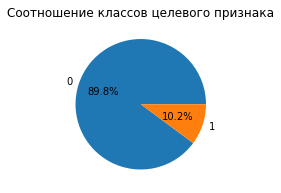

In [20]:
pd.Series(np.bincount(y)).plot(kind='pie', label='', figsize=(3, 3), autopct='%1.1f%%')
plt.title('Соотношение классов целевого признака')
plt.show()

Наблюдаем сильный дисбаланс классов — нулей примерно в девять раз больше, чем единиц. Необходимо будет учесть это при обучении моделей! 

<br><br>

## 1.5. Разделение данных на выборки

Разделим данные в соотношении 3:1 — 75% для обучающей выборки и 25% для тестовой. Учитывая дисбаланс классов, применим параметр `stratify` для сохранения соотношения нулей и единиц для всех выборок на том же уровне, что и в исходном целевом признаке:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RND, stratify=y)

In [22]:
print(color_bold + 'Размер обучающей выборки    :', len(X_train))
print('Размер тестовой выборки     :', len(X_test), reset)

Размер обучающей выборки    : 119469
Размер тестовой выборки     : 39823 


Убедимся, что соотношение нулей и единиц во всех выборках совпадает с изначальным дисбалансом классов в датасете:

In [23]:
get_ballance()
get_ballance(y_train, 'Обучающая выборка')
get_ballance(y_test, 'Тестовая выборка')

————————————————————————————————————————
Исходный датасет:
————————————————————————————————————————
Всего значений   159292
Из них: нулей    143106  (89.84%)
        единиц   16186   (10.16%)

————————————————————————————————————————
Обучающая выборка:
————————————————————————————————————————
Всего значений   119469
Из них: нулей    107330  (89.84%)
        единиц   12139   (10.16%)

————————————————————————————————————————
Тестовая выборка:
————————————————————————————————————————
Всего значений   39823 
Из них: нулей    35776   (89.84%)
        единиц   4047    (10.16%)



ИТАК, в ходе подготовки мы:
- Загрузили и изучили данные
- Провели первичную очистку текста (оставили только английские слова и пробелы)
- Провели лемматизацию текста (привели все слова к начальным формам - леммам)
- Исследовали баланс классов (обнаружен дисбаланс 9:1)
- Разделили данные на обучающую и тестовую выборки

Всё готово для обучения моделей

<br><br><br><br>

# 2. Обучение

Подготовим функцию для вывода результатов подбора параметров моделей:

In [24]:
def show_search_results(model, params, score):
    head_print(f'Модель: {model}', 80)
    print(color_bold + f'Лучшие параметры: {params}' + reset)
    print(color_bold + f'F1 = {round(score, 3)}' + reset)
    print()

Обучим разные модели. Будем использовать пайплайн, для того чтобы TF-IDF векторизатор внутри кросс-валидации обучался только на train-фолдах. Подберём гиперпараметры и выберем лучшую модель по метрике F1:

<br><br>

## 2.1. Модель LogisticRegression

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику F1 на кросс-валидации:

In [25]:
%%time
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))), 
                     ('model', LogisticRegression(class_weight='balanced'))])
# params = {'model__solver': ['newton-cg', 'lbfgs', 'liblinear'], 'model__C': [0.1, 1, 10]}  # best: lbfgs, 10
params = {'model__solver': ['lbfgs'], 'model__C': [10]}

search = GridSearchCV(pipeline, params, scoring='f1', cv=5, n_jobs=-1)
search.fit(X_train['text'], y_train)

logit_score = search.best_score_
logit_model = search.best_estimator_
logit_params = search.best_params_

show_search_results('LogisticRegression', logit_params, logit_score)

————————————————————————————————————————————————————————————————————————————————
Модель: LogisticRegression
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'model__C': 10, 'model__solver': 'lbfgs'}
F1 = 0.756

CPU times: user 2min 20s, sys: 2min 26s, total: 4min 47s
Wall time: 4min 48s


<br><br>

## 2.2. Модель DecisionTreeClassifier

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику F1 на кросс-валидации:

In [26]:
%%time
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))), 
                     ('model', DecisionTreeClassifier(class_weight='balanced', random_state=RND))])
# params = {'model__max_depth': range(9, 19)}  # best 16
params = {'model__max_depth': [16]}

search = GridSearchCV(pipeline, params, scoring='f1', cv=5, n_jobs=-1)
search.fit(X_train['text'], y_train)

dtc_score = search.best_score_
dtc_model = search.best_estimator_
dtc_params = search.best_params_

show_search_results('DecisionTreeClassifier', dtc_params, dtc_score)

————————————————————————————————————————————————————————————————————————————————
Модель: DecisionTreeClassifier
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'model__max_depth': 16}
F1 = 0.605

CPU times: user 1min 17s, sys: 482 ms, total: 1min 18s
Wall time: 1min 18s


<br><br>

## 2.3. Модель CatBoostClassifier

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику F1 на кросс-валидации:

In [27]:
%%time
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))), 
                     ('model', CatBoostClassifier(auto_class_weights='Balanced', random_state=RND, verbose=0))])
# params = {'model__max_depth': [3, 5, 7], 'model__n_estimators': [80, 100]}  # best 5, 100
params = {'model__max_depth': [5], 'model__n_estimators': [100]}

search = GridSearchCV(pipeline, params, scoring='f1', cv=5, n_jobs=-1)
search.fit(X_train['text'], y_train)

cbc_score = search.best_score_
cbc_model = search.best_estimator_
cbc_params = search.best_params_

show_search_results('CatBoostClassifier', cbc_params, cbc_score)

————————————————————————————————————————————————————————————————————————————————
Модель: CatBoostClassifier
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'model__max_depth': 5, 'model__n_estimators': 100}
F1 = 0.725

CPU times: user 14min 12s, sys: 9.68 s, total: 14min 21s
Wall time: 14min 28s


<br><br>

## 2.4. Сравнение результатов

Выведем результаты по всем моделям:

In [28]:
result_table = pd.DataFrame(data={'F1': [logit_score, dtc_score, cbc_score]}, 
                            index=['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'])
result_table['F1'] = result_table['F1'].apply(lambda x: round(x, 3))

print(color_bold + 'Значения метрики F1 для разных моделей\n(рассчитаны на кросс-валидации):' + reset)
display(result_table)

Значения метрики F1 для разных моделей
(рассчитаны на кросс-валидации):


,F1
LogisticRegression,0.756
DecisionTreeClassifier,0.605
CatBoostClassifier,0.725


Наилучший результат показала модель логистической регрессии

<br><br>

## 2.5. Тестирование лучшей модели

Протестируем лучшую модель на тестовой выборке и рассчитаем метрику F1:

In [29]:
pred_test = logit_model.predict(X_test['text'])
score = f1_score(y_test, pred_test)

head_print(f'Модель: LogisticRegression, проверка на тестовой выборке', 80)
print(color_bold + f'F1 = {round(score, 3)}' + reset)

————————————————————————————————————————————————————————————————————————————————
Модель: LogisticRegression, проверка на тестовой выборке
————————————————————————————————————————————————————————————————————————————————
F1 = 0.761


<br><br><br><br>

# 3. Общий вывод

В рамках данного проекта мы решали задачу бинарной классификации (определение токсичности комментариев пользователей Интернет-магазина заказчика). В ходе исследования:

1. Подготовили данные
    - Загрузили и изучили датасет с данными
    - Провели первичную очистку и лемматизацию текста
    - Разделили данные на обучающую и тестовую выборки с учетом выявленного дисбаланса классов


3. Обучили разные модели с различными гиперпараметрами (используя pipeline)
    - Рассмотрели 3 модели машинного обучения: `LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`
    - Векторизовали данные, создали матрицы признаков для моделей ML
    - Оптимизировали качество моделей, меняя гиперпараметры, сравнив результаты по метрике F1, выбрали лучшую
    - Проверили качество лучшей модели на тестовой выборке


Лучшие результаты показала модель `LogisticRegression` с самой высокой метрикой F1 (0.756 на кросс-валидации и 0.761 на тестовой выборке). Также это оказалась единственная модель, соответствующая условиям проекта (F1 > 0.75). Таким образом, мы можем использовать данную модель машинного обучения в рамках задачи заказчика для классификации комментариев на положительные и отрицательные